In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [61]:
train_path = r"C:\nail-disease-detection-dataset\train"
validation_path= r"C:\nail-disease-detection-dataset\validation"

In [62]:
train_folders = [f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))]
print("Folders in the training dataset path:", train_folders)

validation_folders = [f for f in os.listdir(validation_path) if os.path.isdir(os.path.join(validation_path, f))]
print("Folders in the validation dataset path:", validation_folders)

Folders in the training dataset path: ['Acral_Lentiginous_Melanoma', 'blue_finger', 'clubbing', 'Healthy_Nail', 'Onychogryphosis', 'pitting']
Folders in the validation dataset path: ['Acral_Lentiginous_Melanoma', 'blue_finger', 'clubbing', 'Healthy_Nail', 'Onychogryphosis', 'pitting']


In [63]:
folders = ['blue_finger', 'Acral_Lentiginous_Melanoma', 'pitting', 'Onychogryphosis', 'clubbing', 'Healthy_Nail']

In [64]:
import matplotlib.pyplot as plt
from PIL import Image

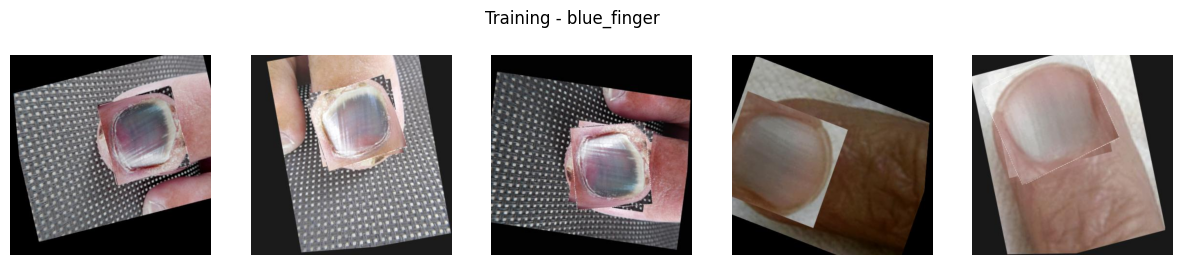

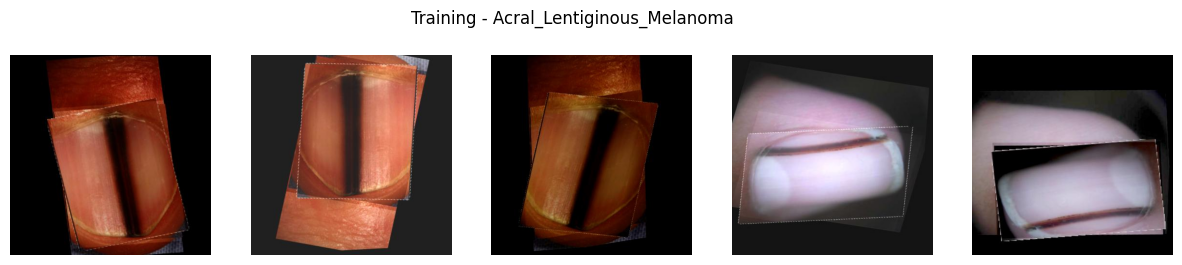

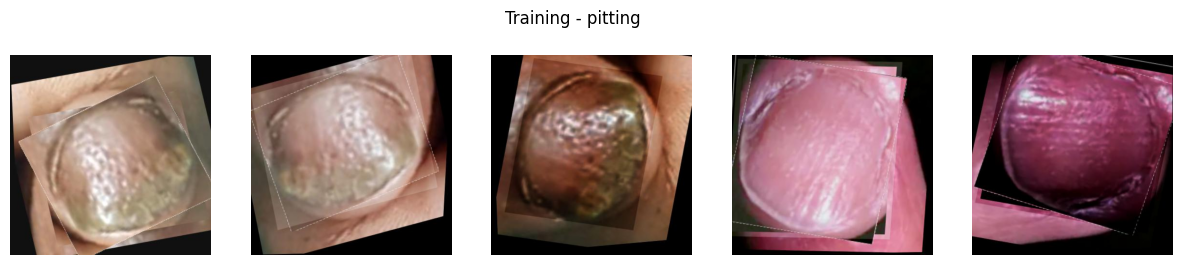

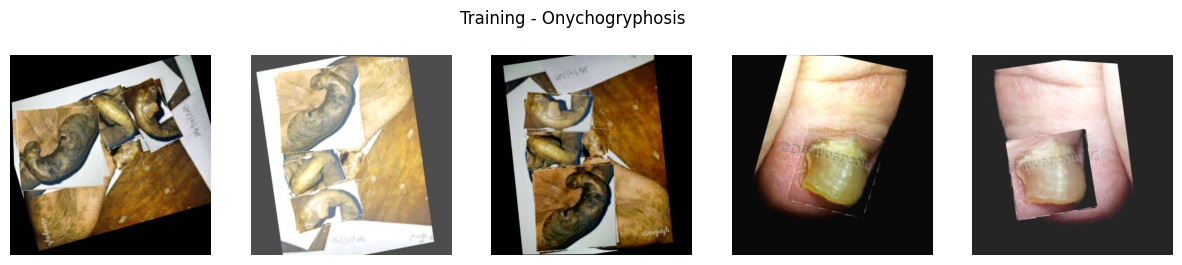

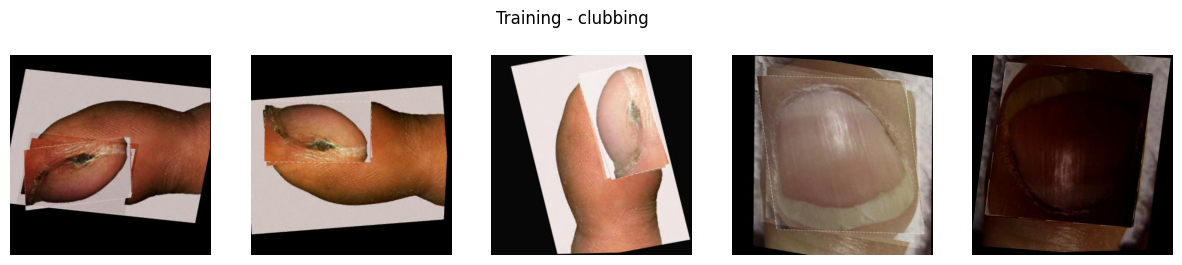

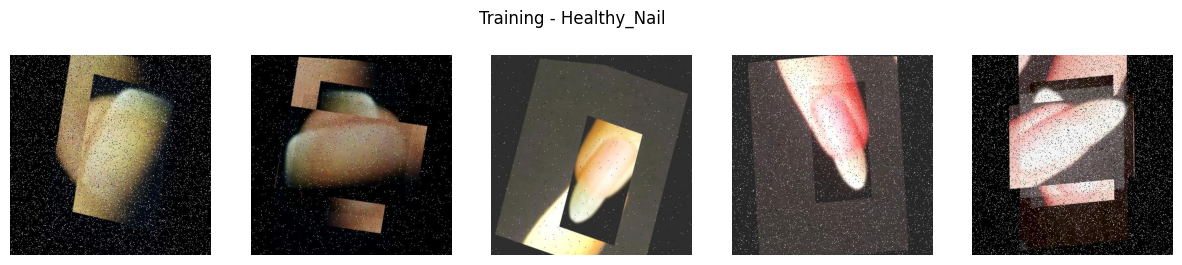

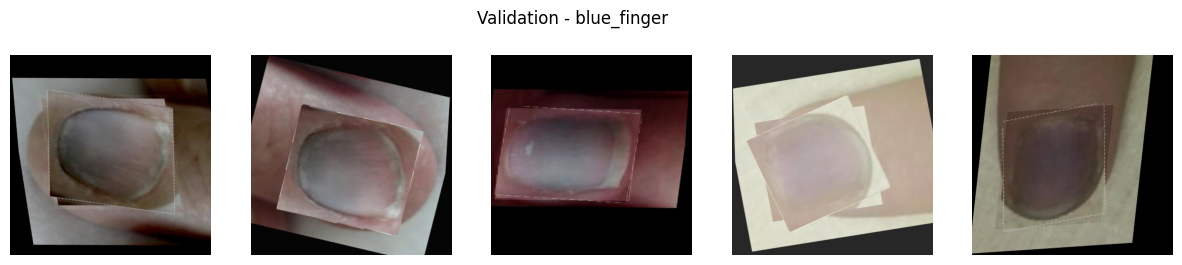

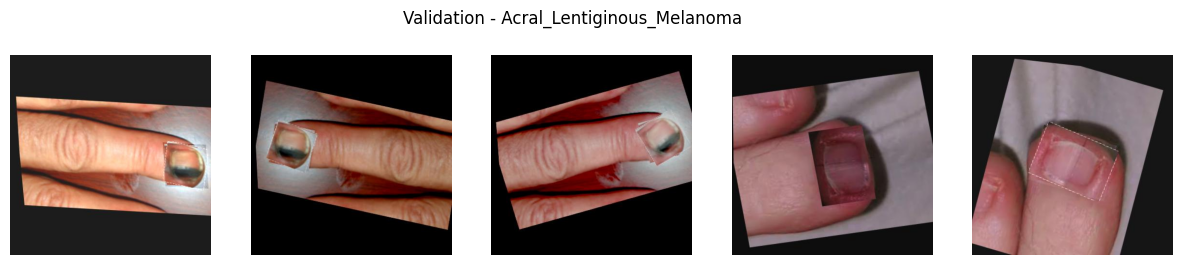

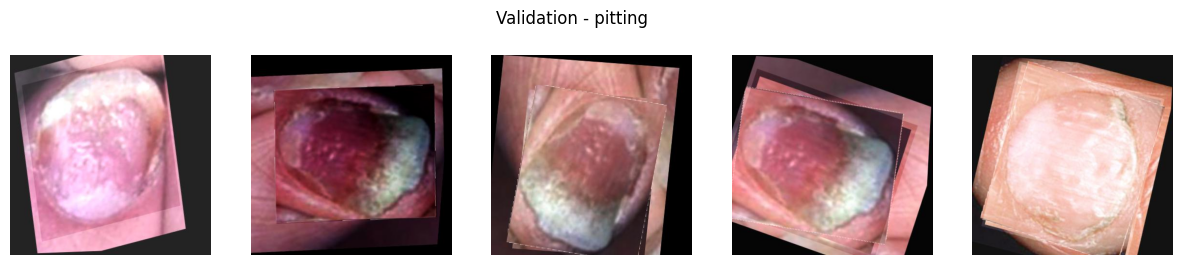

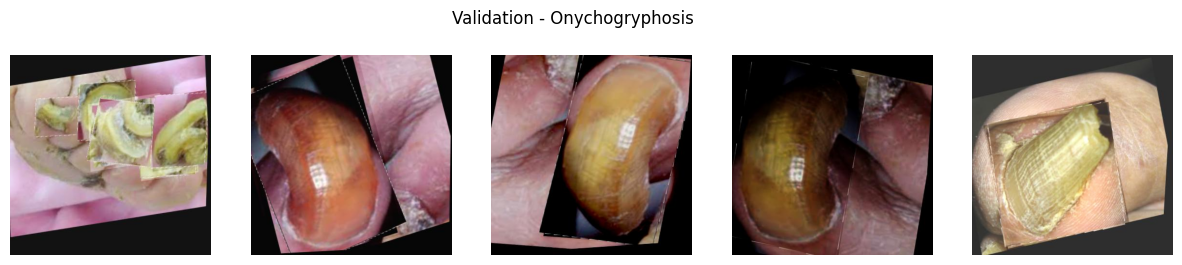

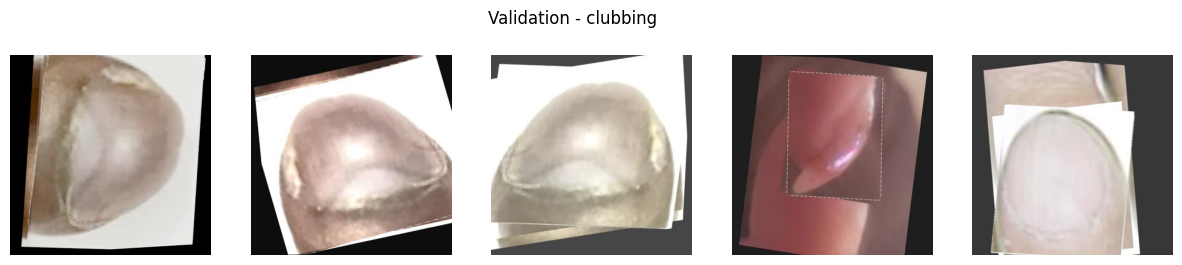

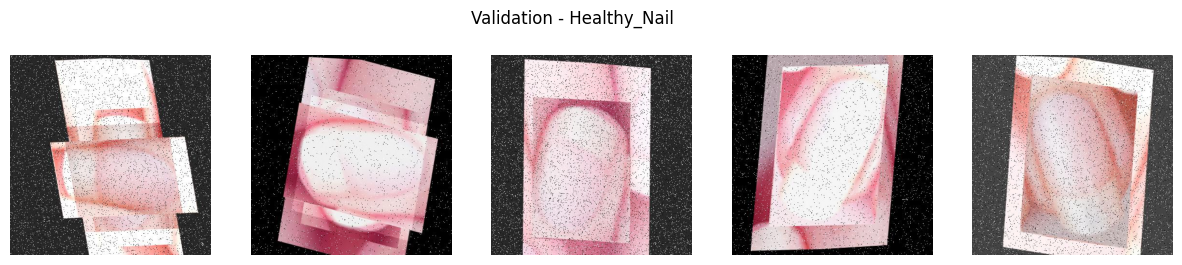

In [65]:
def display_images_from_folder(folder_path, title):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    image_files = image_files[:5]  

    plt.figure(figsize=(15, 3)) 
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(folder_path, image_file)
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

for folder in folders:
    folder_path = os.path.join(train_path, folder)
    display_images_from_folder(folder_path, f'Training - {folder}')

for folder in folders:
    folder_path = os.path.join(validation_path, folder)
    display_images_from_folder(folder_path, f'Validation - {folder}')

In [66]:
def preprocess_image(image_path, size=(128, 128)):
    """Load, resize, and normalize an image."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size)
    img = img / 255.0  
    return img

def save_image(image, save_path):
    """Save a preprocessed image."""
    image = (image * 255).astype(np.uint8)  
    img_pil = Image.fromarray(image)
    img_pil.save(save_path)

def preprocess_and_save_images(folder_path, save_dir, size=(128, 128)):
    """Preprocess and save images from a folder."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            preprocessed_img = preprocess_image(img_path, size)
            save_path = os.path.join(save_dir, filename)
            save_image(preprocessed_img.numpy(), save_path)

In [67]:
preprocess_and_save_images(train_path, train_path)
preprocess_and_save_images(validation_path, validation_path)

In [68]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [69]:
def create_image_dataset(directory, img_size=(128, 128), batch_size=12):
    """Create a TensorFlow dataset from a directory of images."""
    datagen = ImageDataGenerator(rescale=1.0/255,
                                rotation_range=20,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest') 
    
    dataset = datagen.flow_from_directory(
        directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',  
        shuffle=True
    )
    
    return dataset

train_dataset = create_image_dataset(train_path)
val_dataset = create_image_dataset(validation_path)

Found 3744 images belonging to 6 classes.
Found 91 images belonging to 6 classes.


In [70]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_densenet_model(input_shape, num_classes):
    """Create a model using DenseNet121 for image classification."""
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freeze the base model to retain pre-trained features
    base_model.trainable = False
    
    # Add custom layers on top of DenseNet121
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Replace Flatten
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [71]:
input_shape = (128, 128, 3)  
num_classes = len(train_dataset.class_indices)

In [72]:
model = create_densenet_model(input_shape, num_classes)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 38s 1us/step


In [73]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [1]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=300,  
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

NameError: name 'model' is not defined

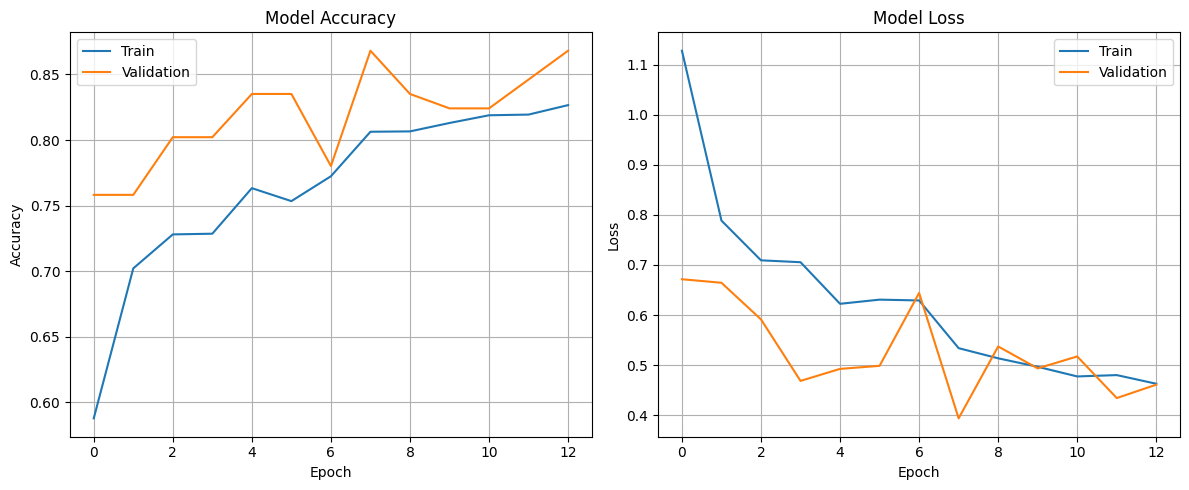

In [75]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [78]:
model.save(r"C:\Users\Rachit Patel\Desktop\Mediscan.Tech\model-api\nail_diseases_model.h5")